# Pollutant data prediction and imputation using online TRMF

## Data Organization: Matrix Structure

>**Reference**: Hsiang-Fu Yu, Nikhil Rao, Inderjit S. Dhillon, 2016. [*Temporal regularized matrix factorization for high-dimensional time series prediction*](http://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf). 30th Conference on Neural Information Processing Systems (*NIPS 2016*), Barcelona, Spain.

We consider a dataset of $m$ discrete time series $\boldsymbol{y}_{i}\in\mathbb{R}^{f},i\in\left\{1,2,...,m\right\}$. The time series may have missing elements. We express spatio-temporal dataset as a matrix $Y\in\mathbb{R}^{m\times f}$ with $m$ rows (e.g., locations) and $f$ columns (e.g., discrete time intervals),

$$Y=\left[ \begin{array}{cccc} y_{11} & y_{12} & \cdots & y_{1f} \\ y_{21} & y_{22} & \cdots & y_{2f} \\ \vdots & \vdots & \ddots & \vdots \\ y_{m1} & y_{m2} & \cdots & y_{mf} \\ \end{array} \right]\in\mathbb{R}^{m\times f}.$$

## Temporal Regularized Matrix Factorization(TRMF)
Temporal Regularized Matrix Factorization (TRMF) framework is an approach to incorporate temporal dependencies into matrix factorization models which use well-studied time series models to describe temporal dependencies
among ${\boldsymbol{x}_t}$ explicitly.Such models take the form:

$$\boldsymbol{x}_{t}\approx\sum_{l\in\mathcal{L}}\boldsymbol{\theta}_{l}\circledast\boldsymbol{x}_{t-l}$$

where this autoregressive (AR) is specialized by a lag set $\mathcal{L}=\left\{l_1,l_2,...,l_d\right\}$ (e.g., $\mathcal{L}=\left\{1,2,144\right\}$) and weights $\boldsymbol{\theta}_{l}\in\mathbb{R}^{r},\forall l$, and we further define

$$\mathcal{R}_{AR}\left(X\mid \mathcal{L},\Theta,\eta\right)=\frac{1}{2}\sum_{t=l_d+1}^{f}\left(\boldsymbol{x}_{t}-\sum_{l\in\mathcal{L}}\boldsymbol{\theta}_{l}\circledast\boldsymbol{x}_{t-l}\right)^T\left(\boldsymbol{x}_{t}-\sum_{l\in\mathcal{L}}\boldsymbol{\theta}_{l}\circledast\boldsymbol{x}_{t-l}\right)+\frac{\eta}{2}\sum_{t=1}^{f}\boldsymbol{x}_{t}^T\boldsymbol{x}_{t}.$$

Thus, TRMF-AR is given by solving

$$\min_{W,X,\Theta}\frac{1}{2}\underbrace{\sum_{(i,t)\in\Omega}\left(y_{it}-\boldsymbol{w}_{i}^T\boldsymbol{x}_{t}\right)^2}_{\text{sum of squared residual errors}}+\lambda_{w}\underbrace{\mathcal{R}_{w}\left(W\right)}_{W-\text{regularizer}}+\lambda_{x}\underbrace{\mathcal{R}_{AR}\left(X\mid \mathcal{L},\Theta,\eta\right)}_{\text{AR-regularizer}}+\lambda_{\theta}\underbrace{\mathcal{R}_{\theta}\left(\Theta\right)}_{\Theta-\text{regularizer}}$$

where $\mathcal{R}_{w}\left(W\right)=\frac{1}{2}\sum_{i=1}^{m}\boldsymbol{w}_{i}^T\boldsymbol{w}_{i}$ and $\mathcal{R}_{\theta}\left(\Theta\right)=\frac{1}{2}\sum_{l\in\mathcal{L}}\boldsymbol{\theta}_{l}^T\boldsymbol{\theta}_{l}$ are regularization terms.

In [2]:
import numpy as np
import scipy.io
from numpy.linalg import inv as inv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time

## Matrix Computation Concepts

### Kronecker product

- **Definition**:

Given two matrices $A\in\mathbb{R}^{m_1\times n_1}$ and $B\in\mathbb{R}^{m_2\times n_2}$, then, the **Kronecker product** between these two matrices is defined as

$$A\otimes B=\left[ \begin{array}{cccc} a_{11}B & a_{12}B & \cdots & a_{1m_2}B \\ a_{21}B & a_{22}B & \cdots & a_{2m_2}B \\ \vdots & \vdots & \ddots & \vdots \\ a_{m_11}B & a_{m_12}B & \cdots & a_{m_1m_2}B \\ \end{array} \right]$$
where the symbol $\otimes$ denotes Kronecker product, and the size of resulted $A\otimes B$ is $(m_1m_2)\times (n_1n_2)$ (i.e., $m_1\times m_2$ columns and $n_1\times n_2$ rows).

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]$ and $B=\left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10 \\ \end{array} \right]$, then, we have

$$A\otimes B=\left[ \begin{array}{cc} 1\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 2\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ 3\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 4\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cccccc} 5 & 6 & 7 & 10 & 12 & 14 \\ 8 & 9 & 10 & 16 & 18 & 20 \\ 15 & 18 & 21 & 20 & 24 & 28 \\ 24 & 27 & 30 & 32 & 36 & 40 \\ \end{array} \right]\in\mathbb{R}^{4\times 6}.$$

### Khatri-Rao product (`kr_prod`)

- **Definition**:

Given two matrices $A=\left( \boldsymbol{a}_1,\boldsymbol{a}_2,...,\boldsymbol{a}_r \right)\in\mathbb{R}^{m\times r}$ and $B=\left( \boldsymbol{b}_1,\boldsymbol{b}_2,...,\boldsymbol{b}_r \right)\in\mathbb{R}^{n\times r}$ with same number of columns, then, the **Khatri-Rao product** (or **column-wise Kronecker product**) between $A$ and $B$ is given as follows,

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2,...,\boldsymbol{a}_r\otimes \boldsymbol{b}_r \right)\in\mathbb{R}^{(mn)\times r}$$
where the symbol $\odot$ denotes Khatri-Rao product, and $\otimes$ denotes Kronecker product.

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]=\left( \boldsymbol{a}_1,\boldsymbol{a}_2 \right) $ and $B=\left[ \begin{array}{cc} 5 & 6 \\ 7 & 8 \\ 9 & 10 \\ \end{array} \right]=\left( \boldsymbol{b}_1,\boldsymbol{b}_2 \right) $, then, we have

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2 \right) $$

$$=\left[ \begin{array}{cc} \left[ \begin{array}{c} 1 \\ 3 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 5 \\ 7 \\ 9 \\ \end{array} \right] & \left[ \begin{array}{c} 2 \\ 4 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 6 \\ 8 \\ 10 \\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cc} 5 & 12 \\ 7 & 16 \\ 9 & 20 \\ 15 & 24 \\ 21 & 32 \\ 27 & 40 \\ \end{array} \right]\in\mathbb{R}^{6\times 2}.$$

In [3]:
def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

In [4]:
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8], [9, 10]])
print(kr_prod(A, B))

[[ 5 12]
 [ 7 16]
 [ 9 20]
 [15 24]
 [21 32]
 [27 40]]


### Load the pollutant data
Shanghai pollutant concentration dataset is stored in a 214 by 8784 tensor `dense_tensor`.
- **214** stands for 214 roads in Guangzhou.
- **8784** stands for 8784 5 mins time slots.

Though the data set have already been through an imputation process by `TRMF`, the data is still not complete because there is no observation of certain pollutant in some stations. The following table shows the observations in Pudong Dongfanglu observation station.

#### Load dataset and Transform data tensor into a matrix

The [4 * 8 * 15791] sized tensor was sliced and concatenated to matrix of size [25 * 15791]. The reason why the first dimension of the matrix is not $4\times8 = 32$ is that there are no observations of certain polltant in some stations. The missing situation are as follows:

* PM10, SO2 and O3 are missing at Pudong Dongfanglu Station.
* SO2 and O3 are missing at Jinan Yananxilu Station.

So we have $4\times8-5 =27$ valid observations.

In [5]:
tensor = scipy.io.loadmat('../Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
print(dense_mat.shape)

(214, 8784)


### Data normalize
Before we feed the raw data into the LSTM network, we need to normalize those inputs and their labels to standard normal distribution as follows:

$$\hat{x}_i = \frac{x_i - x_{min}}{x_{max} - x_{min}}$$

The same $x_{max}$ and $x_{min}$ will be used again to restore the scale and position of predictions.

$$x_i = \hat{x}_i \times (x_{max} - x_{min}) + x_{min}$$

Since the concentrarion data scale of different pollutants observed from different stations are quite different, so they are scaled seperately using sklearn tool `MinMaxScalar`. `MinMaxScalar` is used to conveniently calculate the `min` and `max` of each feature of inital data `X` of size **[sample_num, feature_num]**. ($x_{max}$ and $x_{min}$ are calculated for each feature seperately)

Our `data_mat` is a 25 by 15791 matrix. Here, we can see it as a dataset of 15791 samples(time slots) and each sample contains 25 features(pollutants in different locations). So the data scaling can be done as:

In [6]:
scalar = MinMaxScaler(feature_range=(0, 1))
sc_data_mat = scalar.fit_transform(dense_mat.T).T

print('The size of scaled data_mat:')
print(sc_data_mat.shape)
print()
print('The scaled NO concentrarion data:')
print(sc_data_mat[0, :10])
print()
print('The scaled NO_2 concentrarion data:')
print(sc_data_mat[1, :10])
print()
print('The scaled NO_x concentrarion data:')
print(sc_data_mat[2, :10])
print()
print('The scaled CO concentrarion data:')
print(sc_data_mat[3, :10])
print()
print('The scaled PM_2.5 concentrarion data:')
print(sc_data_mat[4, :10])
print()
print('The scaled PM_10 concentrarion data:')
print(sc_data_mat[5, :10])
print()
print('The scaled SO_2 concentrarion data:')
print(sc_data_mat[6, :10])
print()
print('The scaled O_3 concentrarion data:')
print(sc_data_mat[7, :10])
print()

The size of scaled data_mat:
(214, 8784)

The scaled NO concentrarion data:
[0.79588401 0.81787383 0.86332646 0.87142797 0.86488363 0.8700181
 0.85331005 0.86551492 0.838075   0.86385253]

The scaled NO_2 concentrarion data:
[0.82551033 0.84004516 0.8201337  0.87101457 0.87483198 0.8720899
 0.83841425 0.8736312  0.86746599 0.87087119]

The scaled NO_x concentrarion data:
[0.57426059 0.57135092 0.60031974 0.57626432 0.61762856 0.607919
 0.6052971  0.59927525 0.59472422 0.60944311]

The scaled CO concentrarion data:
[0.74110297 0.74543006 0.69533734 0.77973773 0.82042564 0.77395355
 0.79589809 0.79589809 0.78064288 0.80704698]

The scaled PM_2.5 concentrarion data:
[0.82445465 0.8243344  0.7983357  0.87221915 0.87702927 0.88679381
 0.86185334 0.82077491 0.842204   0.81880276]

The scaled PM_10 concentrarion data:
[0.78890128 0.75316394 0.82557753 0.73528549 0.79375232 0.71998905
 0.82100033 0.78158559 0.75697827 0.70842869]

The scaled SO_2 concentrarion data:
[0.70904934 0.74428965 0.77

## Problem setting
This work mainly focuses on two tasks: missing data imputation and data prediction. Missing data imputation is utilizing history data to complete missing observations. We can use the frame work of Temporal Regularized Matrix Factorization to tackle these two problem at the same time.

### Creating training set and test set

In [7]:
test_rate = 0.3

train_len = int((1 - test_rate) * sc_data_mat.shape[1])
test_len = sc_data_mat.shape[1] - train_len
training_set = sc_data_mat[:, :train_len]
test_set = sc_data_mat[:, train_len:]
print('The size of training set is:')
print(training_set.shape)
print()
print('The size of test set is:')
print(test_set.shape)

The size of training set is:
(214, 6148)

The size of test set is:
(214, 2636)


## Using training set to train TRMF spatial temporal embeddings and AR coefficients

In [8]:
def TRMF(sparse_mat, init, time_lags, lambda_w, lambda_x, lambda_theta, eta, maxiter):
    W = init["W"]
    X = init["X"]
    theta = init["theta"]
    
    dim1, dim2 = sparse_mat.shape
    binary_mat = np.zeros((dim1,dim2))
    position = np.where((sparse_mat != 0))
    binary_mat[position] = 1
#     pos = np.where((dense_mat != 0) & (sparse_mat == 0))
    d = len(time_lags)
    r = theta.shape[1]

    mape = np.zeros(maxiter)
    rmse = np.zeros(maxiter)
    for iter in range(maxiter):
        var1 = X.T
        var2 = kr_prod(var1,var1)
        var3 = np.matmul(var2,binary_mat.T)
        var4 = np.matmul(var1,sparse_mat.T)
        for i in range(dim1):
            W[i,:] = np.matmul(inv((var3[:,i].reshape([r,r]))+lambda_w * np.eye(r)), var4[:,i])

        var1 = W.T
        var2 = kr_prod(var1,var1)
        var3 = np.matmul(var2, binary_mat)
        var4 = np.matmul(var1, sparse_mat)
        for t in range(dim2):
            Mt = np.zeros((r,r))
            Nt = np.zeros(r)
            if t < max(time_lags):
                Pt = np.zeros((r,r))
                Qt = np.zeros(r)
            else:
                Pt = np.eye(r)
                Qt = np.einsum('ij, ij -> j', theta, X[t - time_lags, :])
            if t < dim2 - np.min(time_lags):
                if t >= np.max(time_lags) and t < dim2 - np.max(time_lags):
                    index = list(range(0, d))
                else:
                    index = list(np.where((t + time_lags >= np.max(time_lags)) & (t + time_lags < dim2)))[0]
                for k in index:
                    theta0 = theta.copy()
                    theta0[k, :] = 0
                    Mt = Mt + np.diag(theta[k, :]**2);
                    Nt = Nt + np.multiply(theta[k,:],(X[t+time_lags[k], :] 
                                                                 - np.einsum('ij, ij -> j', theta0,
                                                                             X[t + time_lags[k] - time_lags, :])))
                X[t,:] = np.matmul(inv(var3[:, t].reshape([r,r])
                                       + lambda_x * Pt + lambda_x * Mt + lambda_x * eta * np.eye(r)),
                                   (var4[:, t] + lambda_x * Qt + lambda_x * Nt))
            elif t >= dim2 - np.min(time_lags):
                X[t, :] = np.matmul(inv(var3[:, t].reshape([r, r]) + lambda_x * Pt 
                                        + lambda_x * eta * np.eye(r)), (var4[:, t] + Qt))
        for k in range(d):
            var1 = X[np.max(time_lags) - time_lags[k] : dim2 - time_lags[k], :]
            var2 = inv(np.diag(np.einsum('ij, ij -> j', var1, var1)) + (lambda_theta / lambda_x) * np.eye(r))
            var3 = np.zeros(r)
            for t in range(np.max(time_lags) - time_lags[k], dim2 - time_lags[k]):
                var3 = var3 + np.multiply(X[t, :],
                                          (X[t + time_lags[k], :] 
                                           - np.einsum('ij, ij -> j', theta, X[t + time_lags[k] - time_lags, :])
                                           +np.multiply(theta[k, :], X[t,:])))
            theta[k, :] = np.matmul(var2,var3)

        mat_hat = np.matmul(W, X.T)
#         mape[iter] = np.sum(np.abs(dense_mat[pos] - mat_hat[pos]) / dense_mat[pos]) / dense_mat[pos].shape[0]
#         rmse[iter] = np.sqrt(np.sum((dense_mat[pos] - mat_hat[pos])**2)/dense_mat[pos].shape[0])
    return W, X, theta

**W** is spatial embedding, **X** is temporal embedding and $\text{theta}$ is AR coefficient.

In [27]:
rank = 50
maxiter = 200
lambda_w = 50
lambda_x = 50
lambda_theta = 10
eta = 0.03
time_lags = np.array([1, 2, 144])
dim1, dim2 = training_set.shape
init = {"W": 1.0 * np.random.rand(dim1, rank), "X": 1.0 * np.random.rand(dim2, rank),
                    "theta": 0.1 * np.random.rand(time_lags.shape[0], rank)}
W, X, theta = TRMF(training_set, init, time_lags, 
                   lambda_w, lambda_x, lambda_theta, eta, maxiter)

### Online forecasting with TRMF
In the context of temporal sequence online forecasting, TRMF takes current observations $y_t$ to train the temporal embedding $x_t$. Then, TRMF use $x_{t - \text{time_lags}}$ temporal embeddings to make forecast of future temporal embedding $x_{t+1}$. Finally, forecasted temporal embdding $x_{t+1}$ will be multiplied by spatial embedding W to calculate future speed data.

Utilize pre-trained spatial embedding **W** of size [27, rank], pre-trained AR coefficients **theta**, prestep temporal embedding **X0** of size [max(time_lags), rank] and observations(may be incomplete) to make predictions of the next time step.

In [28]:
def OnlineTRMF(sparse_vec, init, lambda_x, time_lags):
    W = init["W"]
    X = init["X"]
    theta = init["theta"]
    dim = sparse_vec.shape[0]
    t, rank = X.shape
    position = np.where(sparse_vec != 0)
    binary_vec = np.zeros(dim)
    binary_vec[position] = 1
    
    xt_tilde = np.einsum('ij, ij -> j', theta, X[t - 1 - time_lags, :])
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var_mu = np.matmul(var1, sparse_vec) + lambda_x * xt_tilde
    inv_var_Lambda = inv(np.matmul(var2, binary_vec).reshape([rank, rank]) + lambda_x * np.eye(rank))
    return np.matmul(inv_var_Lambda, var_mu)

### Prediction on training set and test set

In [29]:
def online_prediction(sparse_mat, init, time_lags, lambda_w, lambda_x, lambda_theta, eta, maxiter):
    W = init["W"]
    X = init["X"]
    theta = init["theta"]
    pre_step_num = X.shape[0]
    rank = X.shape[1]
    dim1, dim2 = sparse_mat.shape
    X_hat = np.zeros((dim2 + pre_step_num, rank))
    mat_pred = np.zeros((dim1, dim2))
    X_hat[:pre_step_num,:] = X.copy()
    start_time = time.time()
    for t in range(dim2):
        if t == 0:
            X_hat[pre_step_num + t, :] = np.einsum('ij, ij -> j', theta, X_hat[pre_step_num + t - time_lags, :])
        else:
            sparse_vec = sparse_mat[:, t - 1]
            if np.where(sparse_vec > 0)[0].shape[0] > rank:
                init = {"W": W, "X": X_hat[pre_step_num + t - np.max(time_lags) - 1 : pre_step_num + t, :],
                        "theta": theta}
                X_c = OnlineTRMF(sparse_vec, init, lambda_x/dim2, time_lags)
                X_hat[pre_step_num + t - 1, :] = X_c.copy()
                X_hat[pre_step_num + t, :] = np.einsum('ij, ij -> j', theta, X_hat[pre_step_num + t - time_lags, :])
            else:
                X_hat[pre_step_num + t, :] = np.einsum('ij, ij -> j', theta, X_hat[pre_step_num + t - time_lags, :])
        mat_pred[:, t] = np.matmul(W, X_hat[pre_step_num + t, :])
        if (t + 1) % 1000 == 0:
            print('Time step: %d, time cost: %d s'%((t + 1), (time.time() - start_time)))
            start_time = time.time()
            
    sparse_vec = sparse_mat[:, -1]
    init = {"W": W, "X": X_hat[dim2 + pre_step_num - np.max(time_lags) - 1 : , :], "theta": theta}
    X_c = OnlineTRMF(sparse_vec, init, lambda_x/dim2, time_lags)
    X_hat[dim2 + pre_step_num - 1,:] = X_c.copy()
    mat_rec = np.matmul(W, X_hat[pre_step_num : , :].T)
    return mat_rec, mat_pred

### Prediction on training set

In [30]:
import time
start_time = time.time()
init = {"W": W, "X": X[:np.max(time_lags) , :], "theta": theta}
train_mat_rec, train_mat_pred = online_prediction(training_set[:, np.max(time_lags):], init, time_lags
                                     , lambda_w, lambda_x, lambda_theta, eta, maxiter)
print('Shape of imputed data is:')
print(train_mat_rec.shape)
print()
print('Shape of predicted data is:')
print(train_mat_pred.shape)

Time step: 1000, time cost: 2 s
Time step: 2000, time cost: 2 s
Time step: 3000, time cost: 2 s
Time step: 4000, time cost: 2 s
Time step: 5000, time cost: 2 s
Time step: 6000, time cost: 2 s
Shape of imputed data is:
(214, 6004)

Shape of predicted data is:
(214, 6004)


### Prediction on test set

In [31]:
import time
start_time = time.time()
init = {"W": W, "X": X[- np.max(time_lags): , :], "theta": theta}
test_mat_rec, test_mat_pred = online_prediction(test_set, init, time_lags
                                     , lambda_w, lambda_x, lambda_theta, eta, maxiter)
print('Shape of imputed data is:')
print(test_mat_rec.shape)
print()
print('Shape of predicted data is:')
print(test_mat_pred.shape)

Time step: 1000, time cost: 2 s
Time step: 2000, time cost: 2 s
Shape of imputed data is:
(214, 2636)

Shape of predicted data is:
(214, 2636)


### Denormalize of predictions
As we trained the network using normalized data, the datas we predicted are also normalized. Now we want to denormalize them.

In [32]:
# invert predictions
descale_trainPredict = scalar.inverse_transform(train_mat_pred.T).T
descale_trainRec = scalar.inverse_transform(train_mat_rec.T).T
descale_trainY = scalar.inverse_transform(training_set[:, np.max(time_lags):].T).T
descale_testPredict = scalar.inverse_transform(test_mat_pred.T).T
descale_testRec = scalar.inverse_transform(test_mat_rec.T).T
descale_testY = scalar.inverse_transform(test_set.T).T

print(descale_testPredict.shape)
# print(descale_testPredict[:5, 0])
print(descale_testY.shape)
# print(descale_testY[0, :5])

(214, 2636)
(214, 2636)


In [33]:
# invert predictions
descale_trainPredict = train_mat_hat
descale_trainRec = train_mat_rec
descale_trainY = training_set[:, np.max(time_lags):]
descale_testPredict = test_mat_hat
descale_testRec = test_mat_rec
descale_testY = test_set

print(descale_testPredict.shape)
# print(descale_testPredict[:5, 0])
print(descale_testY.shape)
# print(descale_testY[0, :5])

NameError: name 'train_mat_hat' is not defined

In [34]:
print('10 first real value on test set')
print(descale_testY[0,:10])
print()
print('10 first prediciton on test set:')
print(descale_testPredict[0,:10])

10 first real value on test set
[23.699 28.148 24.213 20.492 22.004 27.448 28.174 25.136 22.754 25.685]

10 first prediciton on test set:
[21.91317639 24.03148833 25.81113059 25.50059664 25.11971957 23.86625412
 22.80233679 23.03780914 20.43156628 20.09108424]


### Calculate the prediction error
RMSE(root mean squared error) for both training set and test set are calculated in the following code:

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def root_mean_square_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

### Prediction error

In [36]:
# calculate root mean squared error
trainScore_rmse = root_mean_square_error(descale_trainY, descale_trainPredict)
# trainScore_rmse = np.sqrt(mean_squared_error(descale_trainY, descale_trainPredict))
print('Train Score: %.2f RMSE' % (trainScore_rmse))
trainScore_mape = mean_absolute_percentage_error(descale_trainY, descale_trainPredict)
print('Train Score: %.2f%% MAPE' % (trainScore_mape))
# print()
testScore_rmse = root_mean_square_error(descale_testY, descale_testPredict)
print('Test Score: %.2f RMSE' % (testScore_rmse))
testScore_mape = mean_absolute_percentage_error(descale_testY, descale_testPredict)
print('Test Score: %.2f%% MAPE' % (testScore_mape))

Train Score: 5.95 RMSE
Train Score: inf% MAPE
Test Score: 4.38 RMSE
Test Score: 10.42% MAPE


C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


### Real value and predicted value visualization

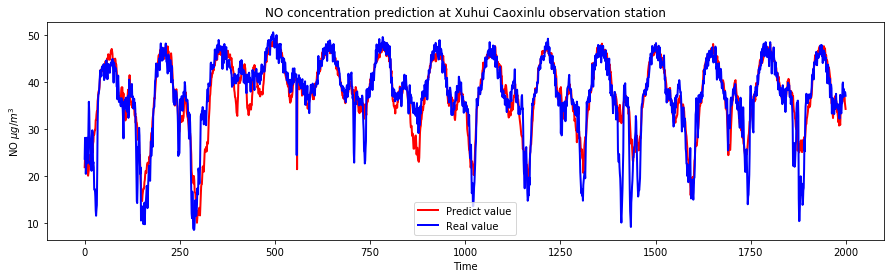

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 4))
pollutant = 0
start_time = 0
end_time = 2000
plt.plot(descale_testPredict[pollutant, start_time:end_time], label = 'Predict value', marker='', markerfacecolor='blue', markersize=8, color='red', linewidth=2)
plt.plot(descale_testY[pollutant, start_time:end_time], label = 'Real value', marker='', markerfacecolor='blue', markersize=8, color='blue', linewidth=2)
plt.title('NO concentration prediction at Xuhui Caoxinlu observation station')
plt.xlabel('Time')
plt.ylabel('NO $\mu g/m^3$')
plt.legend()
plt.show()

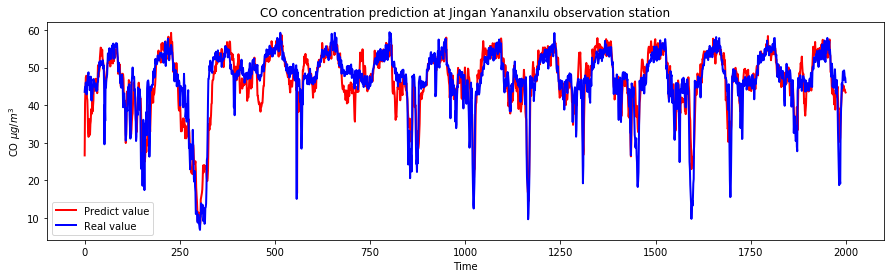

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 4))
pollutant = 1
start_time = 0
end_time = 2000
plt.plot(descale_testPredict[pollutant, start_time:end_time], label = 'Predict value', marker='', markerfacecolor='blue', markersize=8, color='red', linewidth=2)
plt.plot(descale_testY[pollutant, start_time:end_time], label = 'Real value', marker='', markerfacecolor='blue', markersize=8, color='blue', linewidth=2)
plt.title('CO concentration prediction at Jingan Yananxilu observation station')
plt.xlabel('Time')
plt.ylabel('CO $\mu g/m^3$')
plt.legend()
plt.show()

### Imputaion error

In [39]:
# calculate root mean squared error
trainScore_rmse = np.sqrt(mean_squared_error(descale_trainY, descale_trainRec))
print('Train Score: %.2f RMSE' % (trainScore_rmse))
trainScore_mape = mean_absolute_percentage_error(descale_trainY, descale_trainRec)
print('Train Score: %.2f%% MAPE' % (trainScore_mape))
print()
testScore_rmse = np.sqrt(mean_squared_error(descale_testY, descale_testRec))
print('Test Score: %.2f RMSE' % (testScore_rmse))
testScore_mape = mean_absolute_percentage_error(descale_testY, descale_testRec)
print('Test Score: %.2f%% MAPE' % (testScore_mape))

Train Score: 5.24 RMSE
Train Score: inf% MAPE

Test Score: 3.90 RMSE
Test Score: 9.32% MAPE


C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


### Real value and predicted value visualization

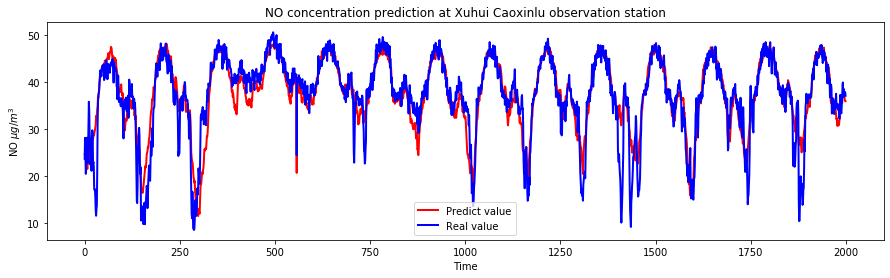

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 4))
pollutant = 0
start_time = 0
end_time = 2000
plt.plot(descale_testRec[pollutant, start_time:end_time], label = 'Predict value', marker='', markerfacecolor='blue', markersize=8, color='red', linewidth=2)
plt.plot(descale_testY[pollutant, start_time:end_time], label = 'Real value', marker='', markerfacecolor='blue', markersize=8, color='blue', linewidth=2)
plt.title('NO concentration prediction at Xuhui Caoxinlu observation station')
plt.xlabel('Time')
plt.ylabel('NO $\mu g/m^3$')
plt.legend()
plt.show()

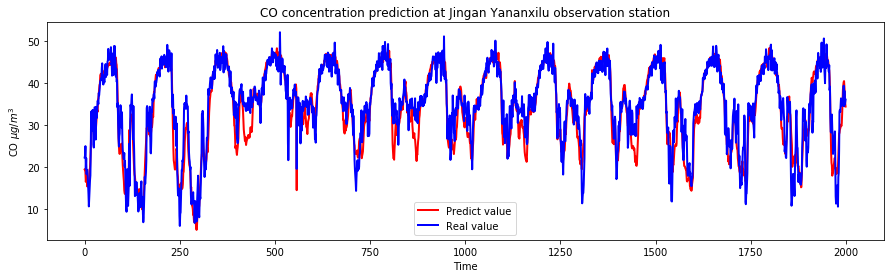

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 4))
pollutant = 11
start_time = 0
end_time = 2000
plt.plot(descale_testRec[pollutant, start_time:end_time], label = 'Predict value', marker='', markerfacecolor='blue', markersize=8, color='red', linewidth=2)
plt.plot(descale_testY[pollutant, start_time:end_time], label = 'Real value', marker='', markerfacecolor='blue', markersize=8, color='blue', linewidth=2)
plt.title('CO concentration prediction at Jingan Yananxilu observation station')
plt.xlabel('Time')
plt.ylabel('CO $\mu g/m^3$')
plt.legend()
plt.show()